# Recent luminous extragalactic transients - joining tables

(Modified from an original by Joe Lyman). 
In this notebook we will be looking for luminous extragalactic transients by ustilising the information provided from the [Sherlock](https://qub-sherlock.readthedocs.io/en/latest/) contextual classifier. We will specifically look for transients that are luminous compared to their host galaxies, where there is a detection in the last 10 days. The aim is to quickly find superluminous supernovae candidates (very bright supernovae that often inhabit dwarf galaxies).

As part of the process we will be looking at joining tables in SQL queries, order to retrieve information about a given `object` from different tables.

First of all we need to do some imports, setup plotting, and connect to the ZTF database

In [1]:
import mysql.connector
import numpy as np
from astropy.table import Table
import astropy.coordinates as coord
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import settings

In [2]:
msl = mysql.connector.connect(
    user=settings.DB_USER, 
    password=settings.DB_PASS, 
    host=settings.DB_HOST, database='ztf')
cursor = msl.cursor()

As an example, lets take a look at what information is provided by the Sherlock crossmatching:

In [3]:
names=['transient_object_id', 'catalogue_object_id', 'catalogue_table_id', 
                                   'separationArcsec', 'northSeparationArcsec', 'eastSeparationArcsec', 'id', 'z', 
                                   'scale', 'distance', 'distance_modulus', 'photoZ', 'photoZErr', 
                                   'association_type', 'dateCreated', 'physical_separation_kpc', 
                                   'catalogue_object_type', 'catalogue_object_subtype', 'association_rank', 
                                   'catalogue_table_name', 'catalogue_view_name', 'rank', 'rankScore', 
                                   'search_name', 'major_axis_arcsec', 'direct_distance', 'direct_distance_scale', 
                                   'direct_distance_modulus', 'raDeg', 'decDeg', 'original_search_radius_arcsec', 
                                   'catalogue_view_id', 'U', 'UErr', 'B', 'BErr', 'V', 'VErr', 'R', 'RErr', 
                                   'I', 'IErr', 'J', 'JErr', 'H', 'HErr', 'K', 'KErr', '_u', '_uErr', 
                                   '_g', '_gErr', '_r', '_rErr', '_i', '_iErr', '_z', '_zErr', '_y', '_yErr', 
                                   'G', 'GErr', 'unkMag', 'unkMagErr', 'dateLastModified', 'updated', 
                                   'classificationReliability', 'transientAbsMag', 'merged_rank']

cursor.execute("SELECT * FROM sherlock_crossmatches LIMIT 10")
results = cursor.fetchall()
table = Table(rows=results, names=names)
table

transient_object_id,catalogue_object_id,catalogue_table_id,separationArcsec,northSeparationArcsec,eastSeparationArcsec,id,z,scale,distance,distance_modulus,photoZ,photoZErr,association_type,dateCreated,physical_separation_kpc,catalogue_object_type,catalogue_object_subtype,association_rank,catalogue_table_name,catalogue_view_name,rank,rankScore,search_name,major_axis_arcsec,direct_distance,direct_distance_scale,direct_distance_modulus,raDeg,decDeg,original_search_radius_arcsec,catalogue_view_id,U,UErr,B,BErr,V,VErr,R,RErr,I,IErr,J,JErr,H,HErr,K,KErr,_u,_uErr,_g,_gErr,_r,_rErr,_i,_iErr,_z,_zErr,_y,_yErr,G,GErr,unkMag,unkMagErr,dateLastModified,updated,classificationReliability,transientAbsMag,merged_rank
int64,str30,int64,float64,float64,float64,int64,object,object,object,object,object,object,str7,object,object,str7,object,object,str18,str42,object,float64,str28,object,object,object,object,float64,float64,float64,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,int64,int64,object,object
1235661,232996065935604352/NCFO028307,71,0.0726043004627,0.0726,-0.0008,6787825,None,None,None,None,None,None,VS,2018-11-02 07:38:47,None,star,multiple,None,GAIA/GSC,multiple,1,1002.0726043,multiple,None,None,None,None,64.3341565914,45.5942731734,0.0,36,None,None,15.3687,0.425363,14.7653,0.379915,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,15.9081842601,None,None,None,2018-11-02 07:38:47,1,1,None,None
1240537,1920670857505734144/23364861+4,71,0.217661047347,0.21677,-0.01975,6787826,None,None,None,None,None,None,VS,2018-11-02 07:38:47,None,star,multiple,None,GAIA/2MASS/GSC/NED,multiple,1,1002.21766105,multiple,None,None,None,None,354.20253545,40.8119608144,0.0,36,None,None,15.5353,0.425884,14.8779,0.318287,None,None,None,None,13.611,0.026,13.219,0.032,13.157,0.029,None,None,None,None,None,None,None,None,None,None,None,None,14.7892467175,None,None,None,2018-11-02 07:38:47,0,1,None,None
1240537,1920670857505734144,71,0.217661047347,0.21677,-0.01975,6787827,None,None,None,None,None,None,VS,2018-11-02 07:38:47,None,star,None,None,Gaia DR1,tcs_view_star_gaia_dr1,None,1002.21766105,gaia star angular,None,None,None,None,354.20253545,40.8119608144,100.0,36,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,14.7892467175,None,None,None,2018-11-02 07:38:47,0,1,None,1
1240537,23364861+4048430,1,0.235023772358,0.221,0.0798,6787828,None,None,None,None,None,None,VS,2018-11-02 07:38:47,None,star,None,None,2MASS PSC,tcs_view_star_2mass_psc_final,None,1002.21766105,2mass star angular,None,None,None,None,354.202572,40.811962,2.5,20,None,None,None,None,None,None,None,None,None,None,13.611,0.026,13.219,0.032,13.157,0.029,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2018-11-02 07:38:47,0,1,None,1
1240537,N07B003337,3,0.404302055948,0.24193,0.32395,6787829,None,None,None,None,None,None,VS,2018-11-02 07:38:47,None,star,0,None,GSC v2.3,tcs_view_star_guide_star_catalogue_v2_3,None,1002.21766105,GSC star 1 angular,None,None,None,None,354.202661592,40.8119678014,100.0,21,None,None,15.5353,0.425884,14.8779,0.318287,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2018-11-02 07:38:47,0,1,None,1
1240537,2MASS J23364861+4048430,68,1.06569666754,1.04,0.22,6787830,None,None,None,None,None,None,SN,2018-11-02 07:38:47,None,galaxy,UvS,None,NED,tcs_view_galaxy_like_ned_stream,None,1002.21766105,ned phot galaxy-like angular,None,None,None,None,354.202625,40.81219,10.0,39,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2018-1

Of interest to us here is to select on objects that have a `sherlock_crossmatches.rank = 1` (i.e. the most likely) crossmatch object that has `sherlock_crossmatches.catalogue_object_type = 'galaxy'`. *(Note we could also try to select objects where the `sherlock_crossmatches.association_type = 'SN'` (supernova) if we wished, you can alter the query below as appropriate, if desired)* We will impose a cut on our objects that the must have at least 8 detections also, for us to assess the light curves - i.e. `objects.ncand > 8`.

We know what objects we want to select, now we need to decide the information (columns) we want to retrieve about the objects and their Sherlock crossmatches. Since we are comparing transient and host galaxy magnitudes, we want to retrieve the brightest `g` and `r` magnitudes from the `objects` table (confusingly named `magrmin` and `maggmin`, currently), and the `_r` and `_g` magnitudes from the `sherlock_crossmatches` table (note the underscores are used distinguish these columns from the other photometric systems in the table, e.g. `R`) - we should also grab the id, name and coordinates of our objects.

Since we require information from two different tables, and we want to retrieve that information for rows that are associated with the same object id, we must use a table `JOIN` and specifically and `ON` condition. You can see this used in the query below - there is plenty of SQL documentation online to find out more about these.

First we compute the current Julian Day from the Unix time:

In [4]:
import time, datetime
now = datetime.datetime.now()
print ("This notbook was run on " + now.isoformat())

jdnow = time.time()/86400 + 2440587.5
print ("and the Julian Date is {}".format(jdnow))

This notbook was run on 2019-06-17T09:04:37.399825
and the Julian Date is 2458651.836543981


Now get the light curve information about all the objects we have found:

In [5]:
query = "SELECT o.primaryid, o.objectid, o.magrmin, o.maggmin, o.ncand, sc._r, sc._g "
query += "FROM sherlock_crossmatches AS sc JOIN objects as o ON sc.transient_object_id = o.primaryid "
query += "WHERE sc.rank = 1 AND sc.catalogue_object_type = 'galaxy' "
query += "AND o.jdmax > {} - 10".format(jdnow)
print(query)

SELECT o.primaryid, o.objectid, o.magrmin, o.maggmin, o.ncand, sc._r, sc._g FROM sherlock_crossmatches AS sc JOIN objects as o ON sc.transient_object_id = o.primaryid WHERE sc.rank = 1 AND sc.catalogue_object_type = 'galaxy' AND o.jdmax > 2458651.836543981 - 10


In [6]:
cursor.execute(query)
results = cursor.fetchall()
table = Table(rows=results, names=["primaryid", "objectid", "magrmin", "maggmin", "ncand", "host_r", "host_g"])
table

primaryid,objectid,magrmin,maggmin,ncand,host_r,host_g
int64,str12,object,object,int64,object,object
1236945,ZTF17aaaaztj,18.6759,19.8674,14,17.4857,18.9144
1238053,ZTF17aaadjky,17.6212,19.8482,72,18.6393,21.1895
1238060,ZTF17aaadjru,18.2355,20.1776,87,20.8903,25.1147
1238141,ZTF17aaadost,18.5486,18.9461,24,17.0435,17.6367
1238219,ZTF17aaadqjt,17.5138,17.4082,20,16.6309,16.7198
1239442,ZTF17aaaeckr,18.5356,None,95,18.1925,21.8784
1239816,ZTF17aaaedvh,17.9462,18.4293,143,16.9578,17.0501
1240030,ZTF17aaaehfp,17.2788,17.4901,33,15.8141,16.3199
1240031,ZTF17aaaehfq,16.8721,16.9794,20,14.0132,14.1722


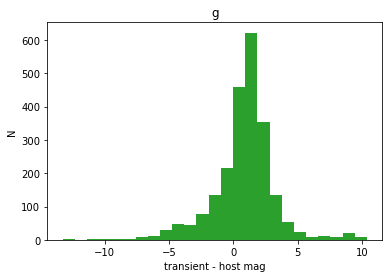

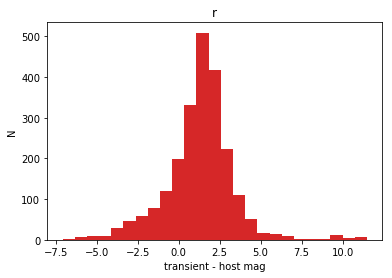

In [7]:
lum_objid = []
for filter_name, tran_mag, host_mag, c in zip(("g", "r"), ("maggmin", "magrmin"), ("host_g", "host_r"), ("C2", "C3")):
    # Remove those where there's no data
    m1 = table[tran_mag] != None
    m2 = table[host_mag] != None
    t = table[m1 & m2]
    # Calculate the magnitude difference
    magdiff = t[tran_mag] - t[host_mag]
    # Store those significantly brighter than their hosts
    lum_objid.extend(t["objectid"][magdiff <= -4])
    # Plot histogram
    plt.hist(magdiff, bins=25, color=c)
    plt.xlabel("transient - host mag")
    plt.ylabel("N")
    plt.title("{}".format(filter_name))
    plt.show()
    
# Remove duplicates (i.e. those added for both g and r filters)
lum_objid = tuple(set(lum_objid))

We can use our list of luminous object ids to grab their lightcurves by querying the `candidates` table.

In [8]:
print(lum_objid)

('ZTF18aajtinl', 'ZTF18abfedgq', 'ZTF18aaripcr', 'ZTF18abmrpun', 'ZTF19aaucspl', 'ZTF18abmmzav', 'ZTF18aaveldl', 'ZTF18aaovwdx', 'ZTF18abcuyrc', 'ZTF19aaynpez', 'ZTF18abkjfzw', 'ZTF19aamjvie', 'ZTF18abtvnxf', 'ZTF18abcdude', 'ZTF18aanbnjh', 'ZTF17aaaeurz', 'ZTF19aaqfdxl', 'ZTF19aayrhsr', 'ZTF19aaynruw', 'ZTF19aaynpjm', 'ZTF18abvhzxn', 'ZTF19aaynpfo', 'ZTF19aawolyt', 'ZTF19aaynrut', 'ZTF18aabqewr', 'ZTF18abygdtf', 'ZTF18aaadwtg', 'ZTF18acojiqg', 'ZTF19aaxwbyx', 'ZTF19aazwxvz', 'ZTF18acvhqfj', 'ZTF19aamvape', 'ZTF19aadnxat', 'ZTF19aazpjya', 'ZTF19aaynnrv', 'ZTF19aarfyvc', 'ZTF19aazpkun', 'ZTF19aaznynm', 'ZTF19aaxbzqp', 'ZTF19aazwjrv', 'ZTF19aapvjob', 'ZTF19aavwbyn', 'ZTF19aazttud', 'ZTF19aavmucr', 'ZTF18abgzdff', 'ZTF18aaoawyk', 'ZTF19aaynpgs', 'ZTF18acvwbek', 'ZTF19aayrlff', 'ZTF19aazplcx', 'ZTF17aaadjru', 'ZTF19aaynowd', 'ZTF18abccpml', 'ZTF19aaqaumz', 'ZTF19aawfepd', 'ZTF18abahaqt', 'ZTF18abncuii', 'ZTF18aceiqfb', 'ZTF17aaawggq', 'ZTF19aarhhfx', 'ZTF18acnephm', 'ZTF19aaqsuys', 'ZTF18a

In [9]:
# Get the light curves
query = "SELECT objectid, jd-{} AS ago, magpsf, sigmapsf, fid FROM candidates WHERE objectid IN {};".format(jdnow, lum_objid)
print(query)
cursor.execute(query)
result = cursor.fetchall()

SELECT objectid, jd-2458651.836543981 AS ago, magpsf, sigmapsf, fid FROM candidates WHERE objectid IN ('ZTF18aajtinl', 'ZTF18abfedgq', 'ZTF18aaripcr', 'ZTF18abmrpun', 'ZTF19aaucspl', 'ZTF18abmmzav', 'ZTF18aaveldl', 'ZTF18aaovwdx', 'ZTF18abcuyrc', 'ZTF19aaynpez', 'ZTF18abkjfzw', 'ZTF19aamjvie', 'ZTF18abtvnxf', 'ZTF18abcdude', 'ZTF18aanbnjh', 'ZTF17aaaeurz', 'ZTF19aaqfdxl', 'ZTF19aayrhsr', 'ZTF19aaynruw', 'ZTF19aaynpjm', 'ZTF18abvhzxn', 'ZTF19aaynpfo', 'ZTF19aawolyt', 'ZTF19aaynrut', 'ZTF18aabqewr', 'ZTF18abygdtf', 'ZTF18aaadwtg', 'ZTF18acojiqg', 'ZTF19aaxwbyx', 'ZTF19aazwxvz', 'ZTF18acvhqfj', 'ZTF19aamvape', 'ZTF19aadnxat', 'ZTF19aazpjya', 'ZTF19aaynnrv', 'ZTF19aarfyvc', 'ZTF19aazpkun', 'ZTF19aaznynm', 'ZTF19aaxbzqp', 'ZTF19aazwjrv', 'ZTF19aapvjob', 'ZTF19aavwbyn', 'ZTF19aazttud', 'ZTF19aavmucr', 'ZTF18abgzdff', 'ZTF18aaoawyk', 'ZTF19aaynpgs', 'ZTF18acvwbek', 'ZTF19aayrlff', 'ZTF19aazplcx', 'ZTF17aaadjru', 'ZTF19aaynowd', 'ZTF18abccpml', 'ZTF19aaqaumz', 'ZTF19aawfepd', 'ZTF18abahaqt', '

In [10]:
ztf_lc_res = Table(rows=result, names=("objectid", "ago", "magpsf", "sigmapsf", "fid")).group_by("objectid")
ztf_lc_res

objectid,ago,magpsf,sigmapsf,fid
str12,float64,float64,float64,int64
ZTF17aaadjru,-367.945768481,19.6261,0.0871863,2
ZTF17aaadjru,-365.924379581,19.7302,0.0933317,2
ZTF17aaadjru,-363.887319481,19.8611,0.117233,2
ZTF17aaadjru,-362.882909681,19.453,0.200822,2
ZTF17aaadjru,-350.938280081,19.1815,0.179394,2
ZTF17aaadjru,-343.944333381,19.1956,0.117234,2
ZTF17aaadjru,-332.971312481,19.7872,0.181459,2
ZTF17aaadjru,-331.982400481,19.2817,0.143005,2
ZTF17aaadjru,-330.940594881,19.3932,0.146914,2


For each luminous object, plot the light curve

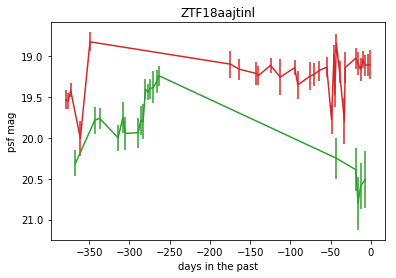

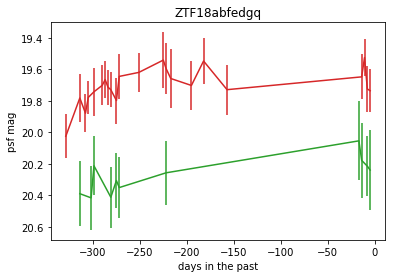

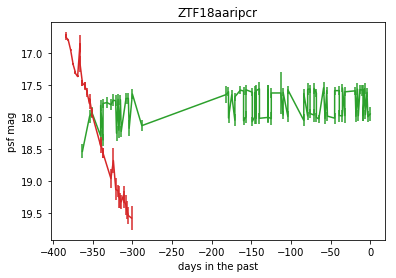

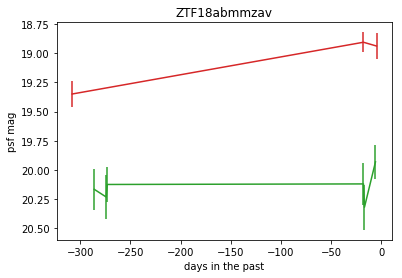

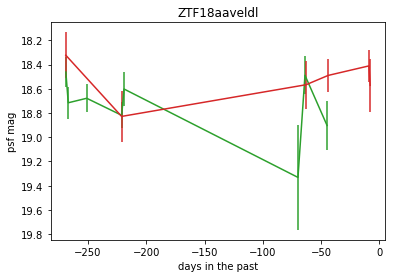

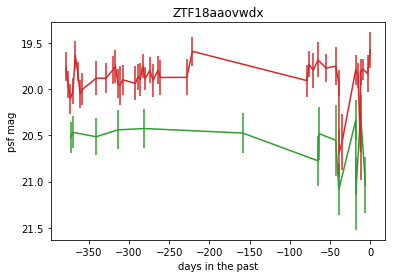

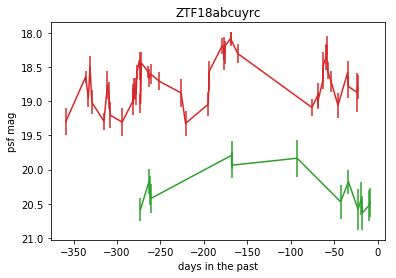

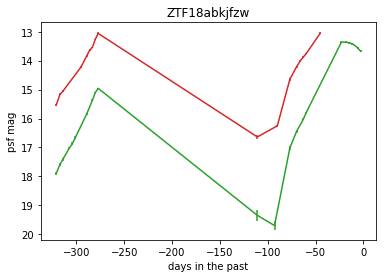

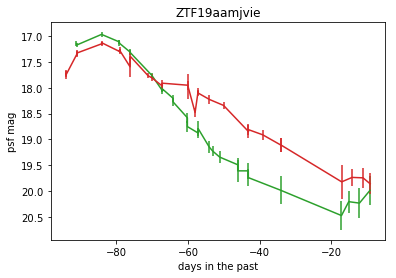

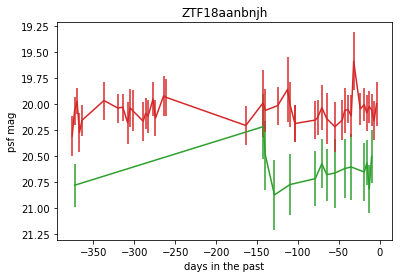

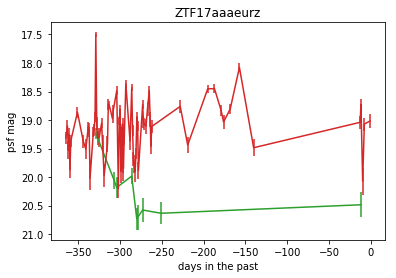

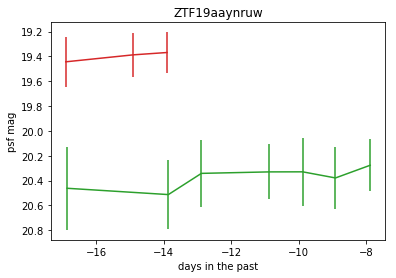

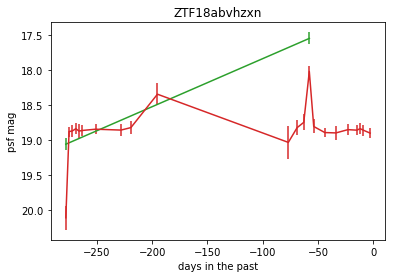

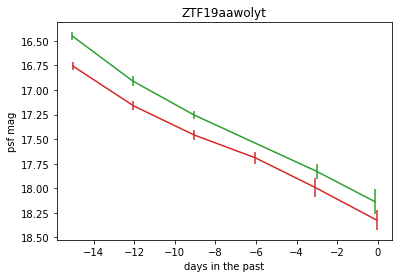

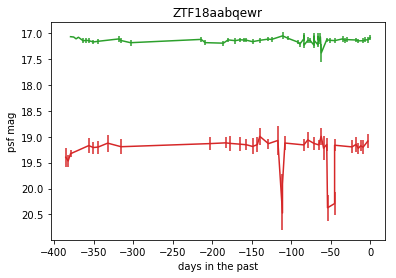

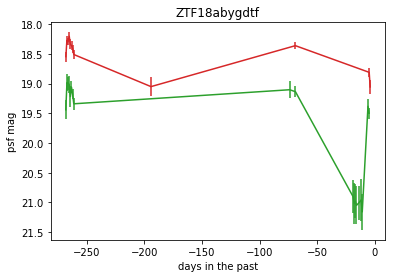

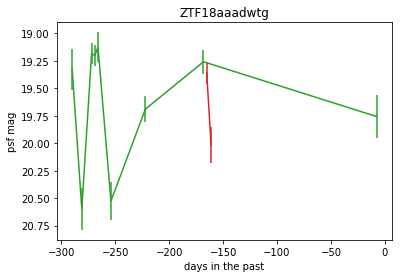

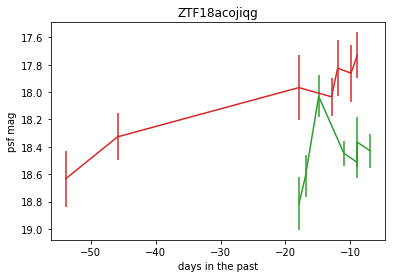

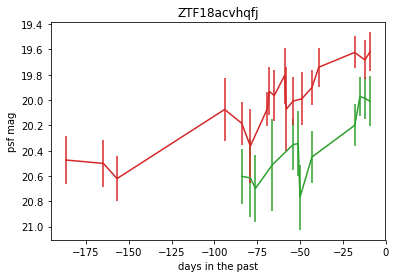

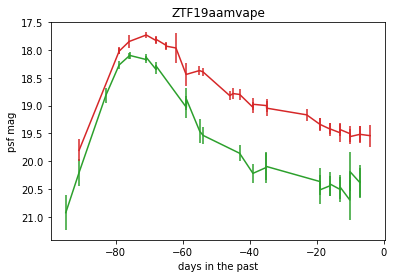

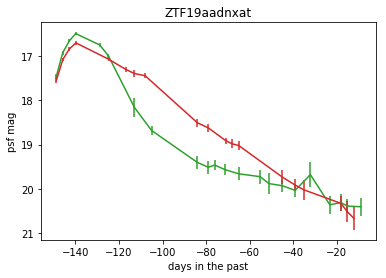

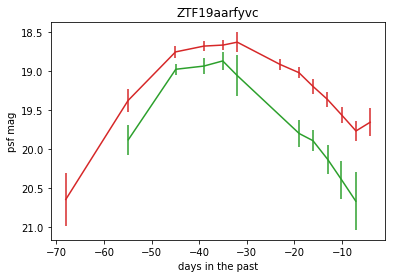

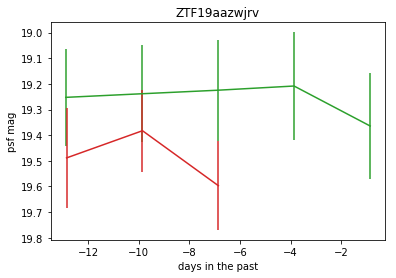

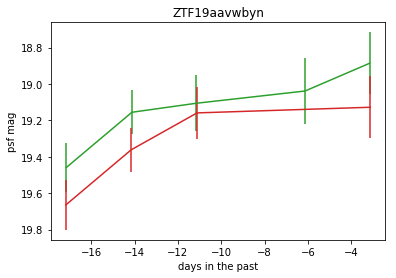

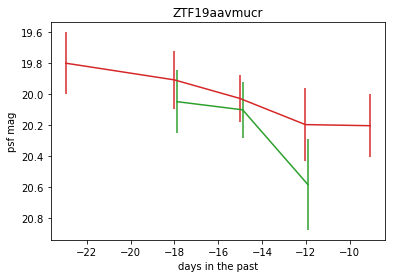

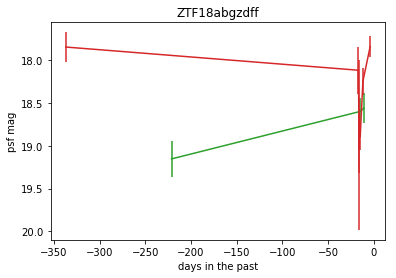

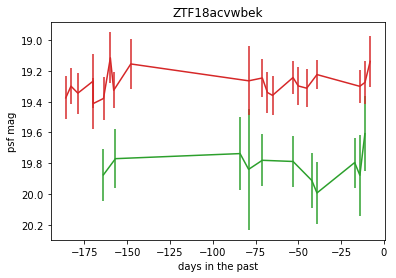

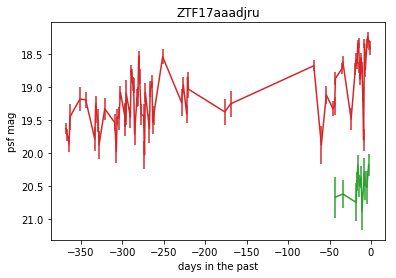

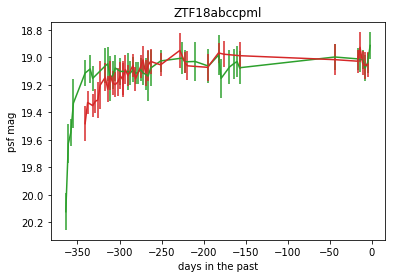

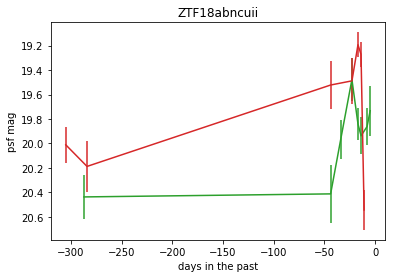

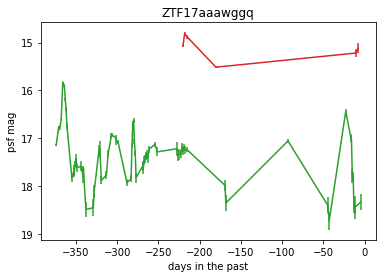

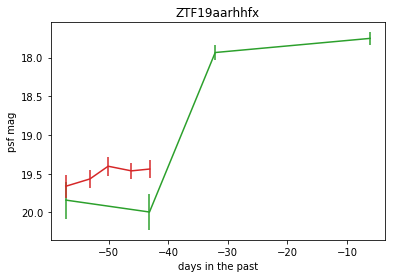

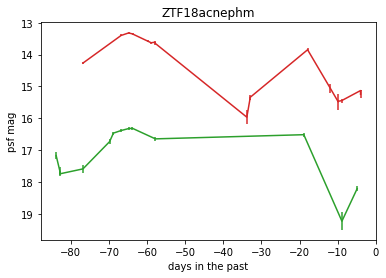

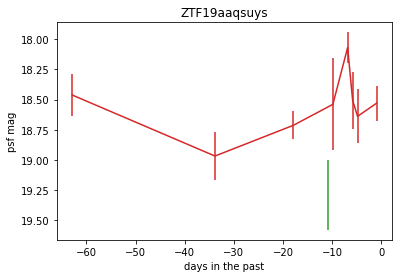

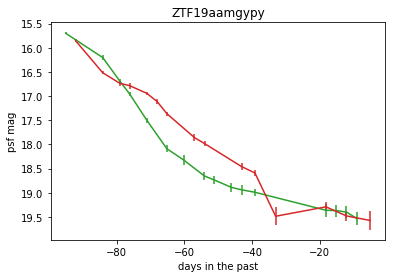

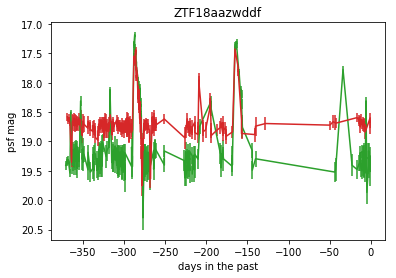

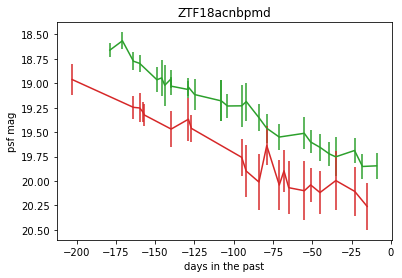

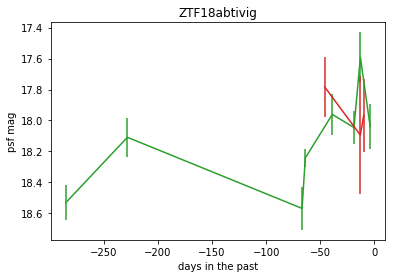

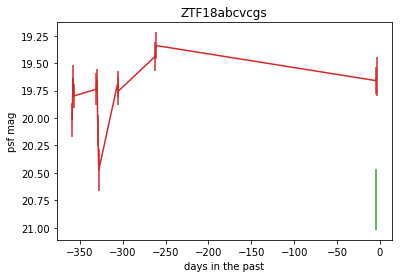

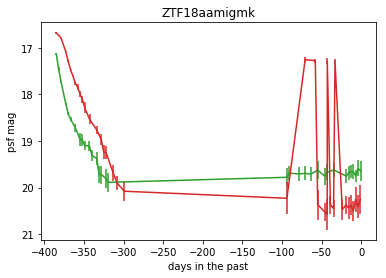

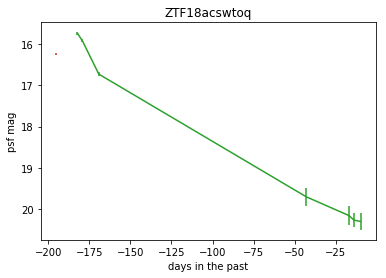

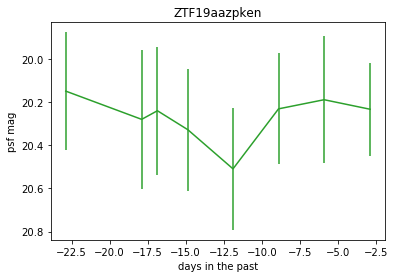

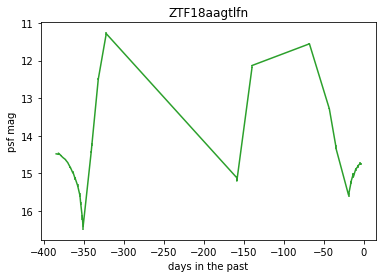

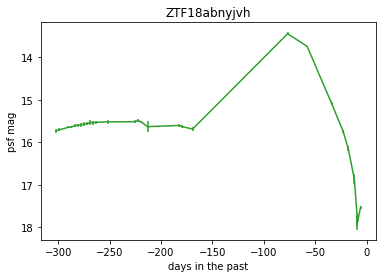

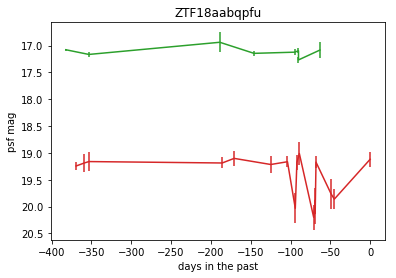

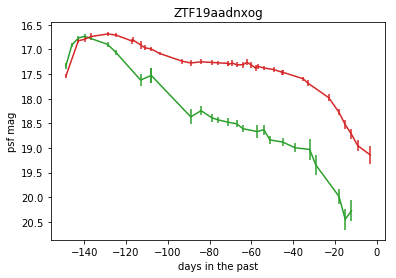

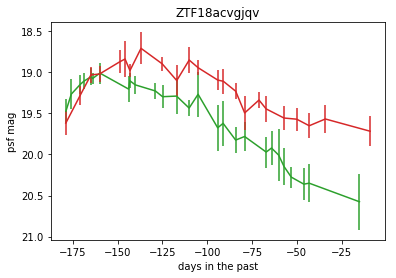

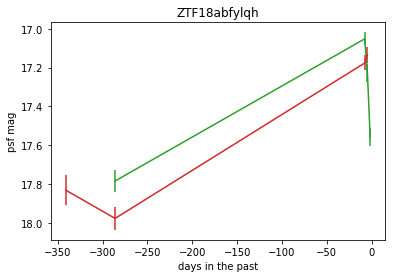

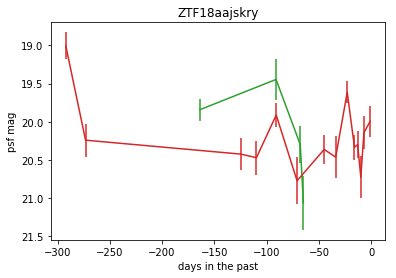

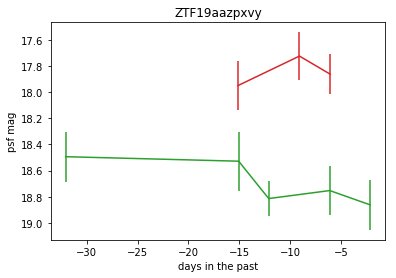

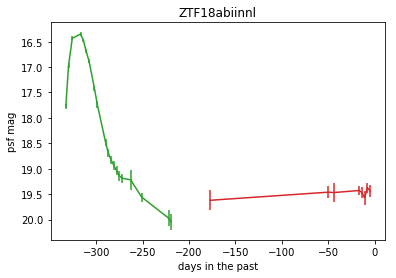

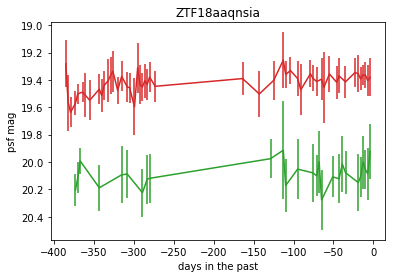

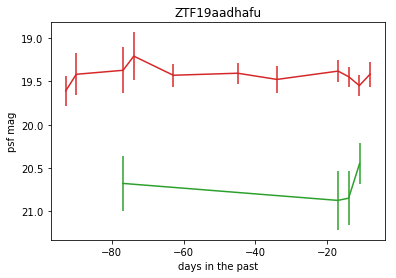

In [11]:
for objid in lum_objid:
    lc = ztf_lc_res[ztf_lc_res["objectid"] == objid]
    if len(lc) < 8:
        continue
    lcg = lc[[lc["fid"] == 1]]
    plt.errorbar(lcg["ago"], lcg["magpsf"], yerr=lcg["sigmapsf"], c="C2")
    lcr = lc[[lc["fid"] == 2]]
    plt.errorbar(lcr["ago"], lcr["magpsf"], yerr=lcr["sigmapsf"], c="C3")
    plt.xlabel("days in the past")
    plt.ylabel("psf mag")
    plt.title("{}".format(objid))
    plt.gca().invert_yaxis()
    plt.show()